# Practical exploration of EuroSAT dataset

## Overview
EuroSAT is a large-scale land use and land cover classification dataset derived from multispectral Sentinel-2 satellite imagery covering European continent. EuroSAT is composed of 27,000 georeferenced image patches (64 x 64 pixels) - each patch comprises 13 spectral bands (optical through to shortwave infrared ) resampled to 10m spatila resolution and labelled with one of 10 distinct land cover classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake. Full details including links to journal papers and download instructions may be found here: https://github.com/phelber/eurosat.

![EuroSAT](https://github.com/phelber/EuroSAT/raw/master/eurosat_overview_small.jpg?raw=true)

## Method

This GitHub project outlines a basic Keras / TensorFlow implementation for performing multiclass single-label classification using a Convolutional Neural Network trained with multispectral satellite imagery. A custom image generator was created to manage streaming of augmented multispectral training images from disc as exemplified by work published in the following repository: https://github.com/mabdelhack/hyperspectral_image_generator 

EuroSAT dataset was randomly split 80-20 into training / test subsets encoded as pandas data frames with records comprising image pathname, class id and one hot-encoding (OHE) vector. EuroSAT is reasonally well-balanced dataset with 2000-3000 samples available for each land cover class - records were randomly duplicated to equalize class populations to 3000 samples.

In [1]:
# authentication key
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='C:/Users/Chris.Williams/.gcs/arkham-255409-c59a52d8653f.json'

In [2]:
# define repo name and get root working directory
repo = 'eurosat'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\eurosat'

In [3]:
# add repo source directory to system path
import sys
sys.path.insert(0, os.path.join( root_path, 'src' ) )

In [4]:
from google.cloud import storage
from io import BytesIO

# download pretrained model from google cloud
#client = storage.Client()
#bucket = client.get_bucket('eo-ald-update')

# construct remote path
filenames = [ 'models/vgg16-256-128.zip', 'data.zip' ]

# check files exist
for f in filenames:

    pathname = os.path.join( os.getcwd(), f )
    if not os.path.exists( pathname ):
                
        # make sub-directory if required
        if not os.path.exists ( os.path.dirname( pathname ) ):
            os.makedirs( os.path.dirname( pathname ) )

        # download blob
        remote_url = '{}/{}'.format( repo, f )

        blob = storage.blob.Blob( remote_url, bucket)
        with open( pathname, 'w+b' ) as z:
            blob.download_to_file( z )

In [5]:
from zipfile import ZipFile

# extract downloaded zip files 
for f in filenames:
    pathname = os.path.join( os.getcwd(), f )
#    with ZipFile( pathname, 'r') as zipObj:
       # extract contents to current directory
#       zipObj.extractall( os.path.dirname( pathname ) )

In [6]:
# zip class names into dict
labels = [  "AnnualCrop", 
            "Forest", 
            "HerbaceousVegetation", 
            "Highway", 
            "Industrial", 
            "Pasture", 
            "PermanentCrop", 
            "Residential",
            "River", 
            "SeaLake" ]

classes = dict(zip( labels,range (len(labels) ) ) )

In [7]:
import pandas as pd

# read subset csv files into data frames
df = { 'train' : None, 'test' : None }
for subset in [ 'train', 'test' ]:
    df[ subset ] = pd.read_csv( os.path.join( os.getcwd(), 'data/{}.csv'.format( subset ) ) )
    
    # update image pathnames
    df[ subset ]['pathname'] = df[ subset ]['pathname'].apply(lambda x: 
                                      x.replace( os.path.dirname(x)[ 0 : os.path.dirname(x).find( repo ) + len ( repo ) ], root_path) )   
df[ 'train' ].head(5)

,pathname,class,id
0,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0
1,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0
2,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0
3,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0
4,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0


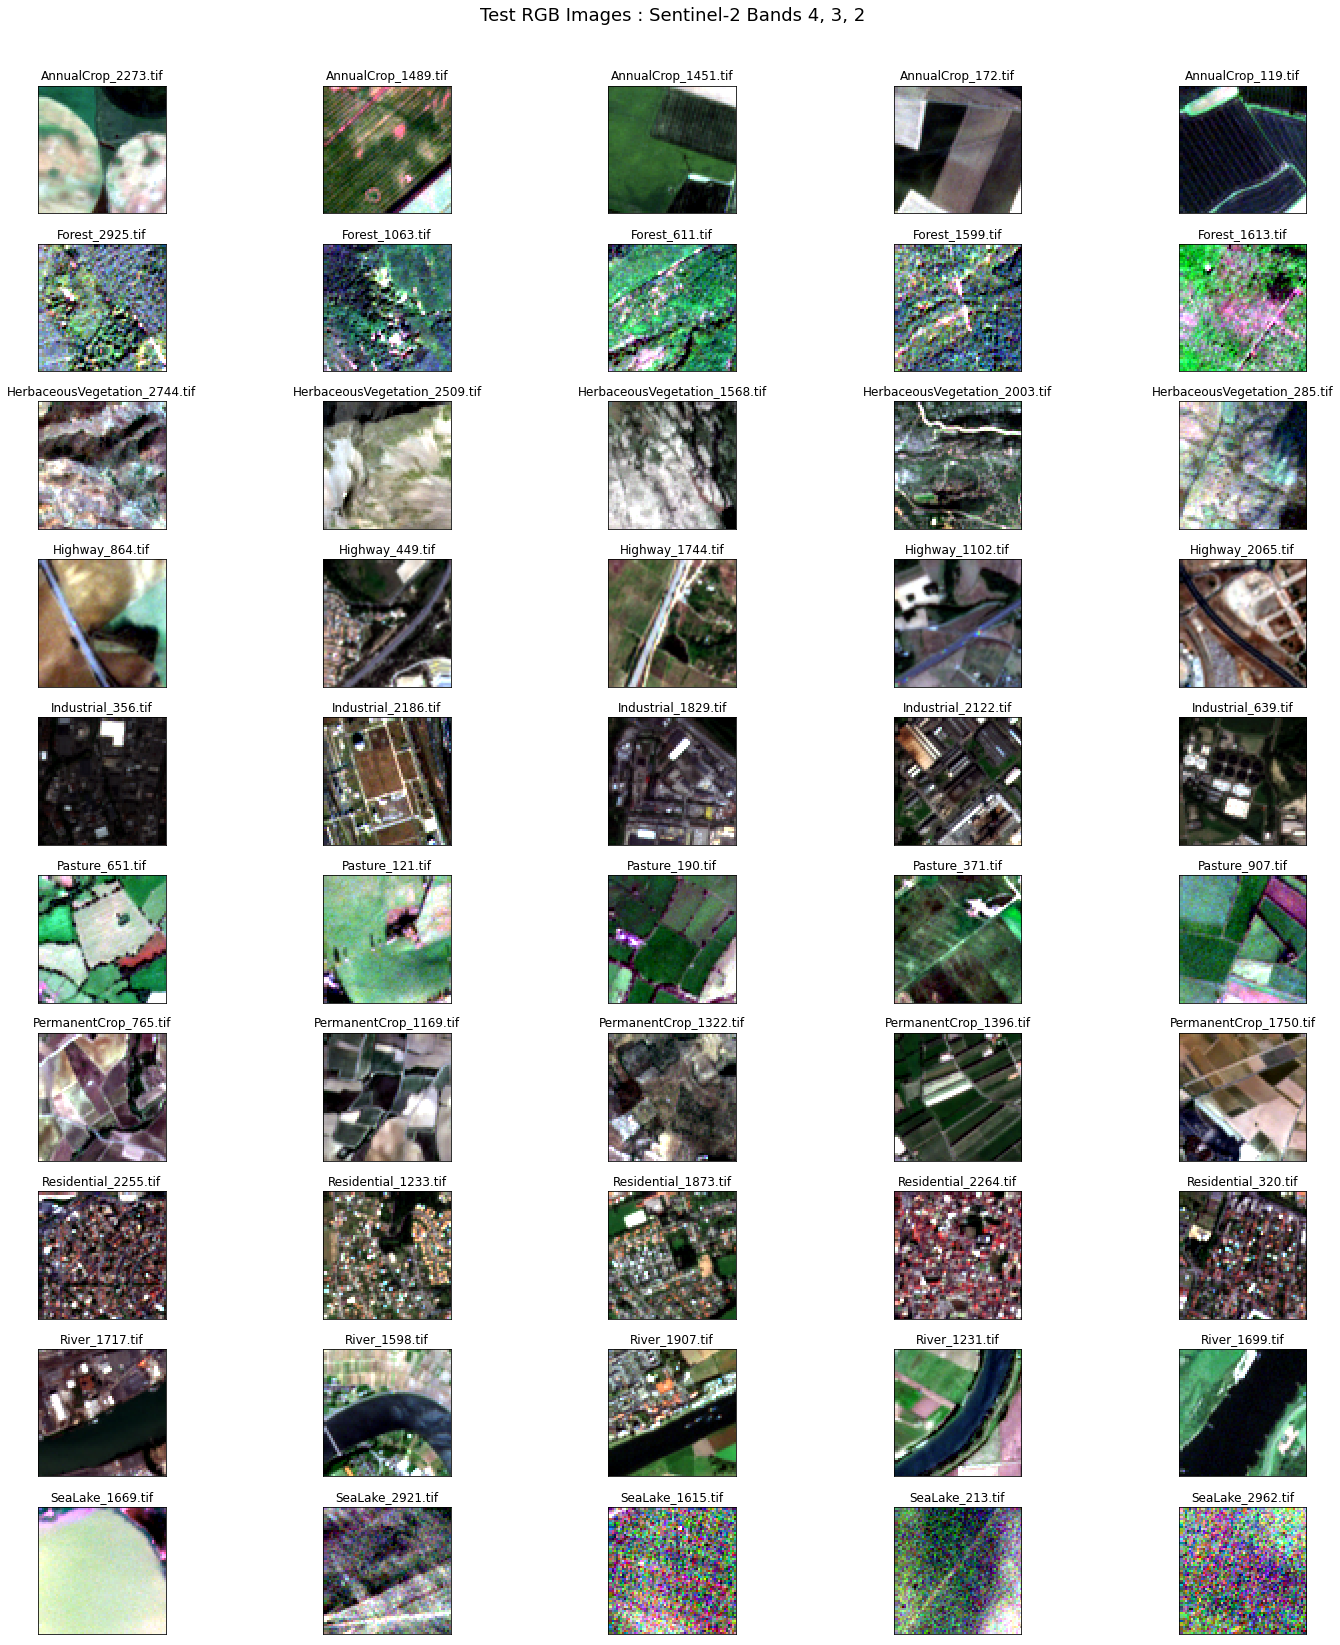

In [8]:
import gdal
import numpy as np
import matplotlib.pyplot as plt

# define figure content
nrows=len(classes); ncols=5

# create figure
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 24))
fig.suptitle('Test RGB Images : Sentinel-2 Bands 4, 3, 2', fontsize=18)

# plot rgb bands of randomly selected test images
test = df[ 'test']; bands = [ 4,3,2 ]
for row, c in enumerate( classes ):

    # pick random sample from each class population
    subset = test [ test[ 'class'] == c ]
    sample = subset.sample(ncols) 
    
    col = 0
    for idx, record in sample.iterrows():
        
        # use gdal to open multispectral 16-bit imagery
        ds = gdal.Open( record[ 'pathname'] )
        
        rgb = []
        for bid in bands:

            # read band data
            band = np.asarray( ds.GetRasterBand( bid ).ReadAsArray(), dtype=float )
            
            # compute 16-bit to 8bit min / max scaling factors
            r = np.percentile( band, [ 2, 98 ] )            
            band = (( band - r[0]) / (r[1] - r[0] ) ) * 255.0
            
            # clip to 8bit
            band = np.clip( band, a_min=0.0,a_max=255.0 )
            rgb.append ( np.asarray( band, dtype=np.uint8 ) )
            
        # display rgb image and filename title
        axes[ row ][ col ].imshow( np.asarray( np.dstack( rgb ) ) )
        axes[ row ][ col ].set_title( '{}'.format ( os.path.basename( record[ 'pathname' ] ) ) )
        
        # remove axes ticks
        axes[ row ][ col ].get_xaxis().set_ticks([])
        axes[ row ][ col ].get_yaxis().set_ticks([])
        
        col += 1

# tight layout with adjustment
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
        

## Model
A VGG-16-based CNN - preloaded with ImageNet weights - was selected as backbone for image feature extraction. The topmost layer of VGG16 CNN was attached to two fully connected 'Relu'-layers comprising 256 and 128 units respectively with dropout for regularization. The output layer comprised a single unit with softmax activation function to implement the classification. 

![Model Architecture](assets/architecture.png)

## Results
The model was trained minimising categorical cross entropy loss function with Adam optimiser configured with a learning rate of 1e-6. High training and validation categorical accuracies (> 0.9) were reported after 100-150 epochs. Inference analysis in the form of a confusion matrix confirmed the model had acquired the capacity to accurately identify different land cover types. It should be noted that predictive accuracy for Highways class (~0.8) was suspectible to increased error where samples were incorrectly classified as 'Residential' and 'Industrial'. 

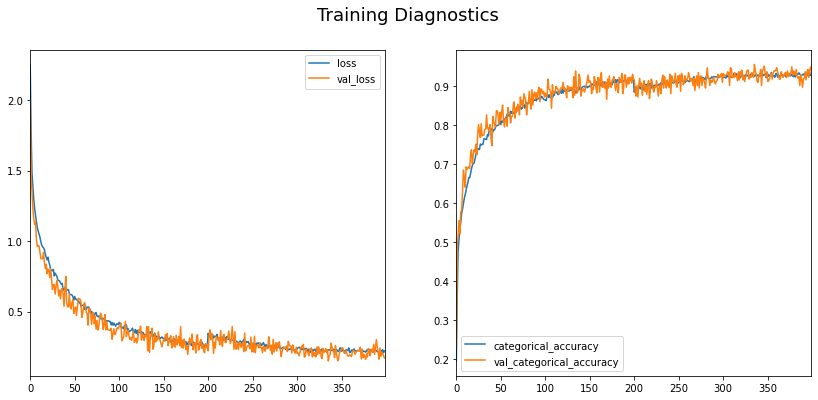

In [9]:
# load class-specific diagnostics from csv file
path = 'models/vgg16-256-128/'
df[ 'log' ] = pd.read_csv( os.path.join( path, 'log.csv') )

# create figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.suptitle('Training Diagnostics', fontsize=18)

# plot diagnostics of model 
df[ 'log' ].plot.line( ax=axes[0], y=['loss'])
df[ 'log' ].plot.line( ax=axes[0], y=['val_loss'])

# plot diagnostics of model 
df[ 'log' ].plot.line( ax=axes[1], y=['categorical_accuracy'])
df[ 'log' ].plot.line( ax=axes[1], y=['val_categorical_accuracy'])

In [10]:
# read global band statistics
stats = pd.read_csv( os.path.join( os.getcwd(), 'data/stats.csv' ) )
stats.head(13)

,channel,mean,stdev
0,0.0,1353.726926,245.291394
1,1.0,1117.202292,333.440529
2,2.0,1041.884725,395.219478
3,3.0,946.554255,594.478647
4,4.0,1199.188664,567.013831
5,5.0,2003.006800,861.019421
6,6.0,2374.008444,1086.971864
7,7.0,2301.220438,1118.319564
8,8.0,732.181950,403.844254
9,9.0,12.099528,4.729379


In [11]:
from keras.utils import to_categorical

# data frame amendments
for subset in [ 'train', 'test' ]:   

    # add one hot encoder column to data frames
    df[ subset ][ 'target' ] = tuple ( to_categorical(  df[ subset ][ 'id' ], num_classes=len( classes ) ) )

df['train'].head(5)

Using TensorFlow backend.
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtype

,pathname,class,id,target
0,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C:\Users\Chris.Williams\Documents\GitHub\euros...,AnnualCrop,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
# load pre-trained model from file - downloaded from GCS
from model import loadFromFile
model, model_type = loadFromFile( 'models/vgg16-256-128' )






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Loaded model from disk: models/vgg16-256-128


In [13]:
from generator import MultiChannelImageDataGenerator

def getPrediction( model, df, stats ):

    """
    generate prediction for images referenced in data frame
    """

    # create generator
    batch_size = 1
    generator = MultiChannelImageDataGenerator( [ df ],
                                                batch_size,
                                                stats=stats,
                                                shuffle=False )

    # initiate prediction
    steps = len( df ) // batch_size
    y_pred = model.predict_generator( generator, steps=steps )

    # return index of maximum softmax value
    return np.argmax( y_pred, axis=1 )

In [14]:
from sklearn.metrics import confusion_matrix

def getConfusionMatrix( actual, predict, labels ):

    """
    compute confusion matrix for prediction
    """

    # compute normalised confusion matrix 
    cm = confusion_matrix( actual, predict )
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # parse normalised confusion matrix into dataframe
    return pd.DataFrame( cm, index=labels, columns=labels )

In [15]:
import seaborn as sn

def plotConfusionMatrix( cm, subset ):

    """
    plot train and test confusion matrix
    """

    # create figure
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

    # plot heatmap - adjust font and label size
    sn.set(font_scale=1.0) 
    sn.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='.2f', ax=axes )

    axes.set_title( 'Normalised Confusion Matrix: {}'.format( subset ) )
    plt.show()

    return

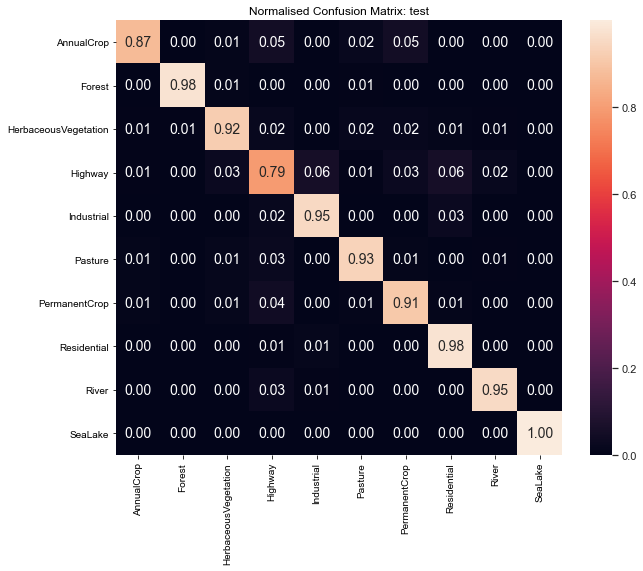

In [16]:
import numpy as np

# generate actual vs prediction
# for subset in [ 'train', 'test' ]:
for subset in [ 'test' ]:

    actual = np.asarray( df[ subset ][ 'id' ].tolist(), dtype=int )
    predict = getPrediction( model, df[ subset ], stats )

    # get confusion matrix
    cm = getConfusionMatrix( actual, predict, classes.keys() )

    # plot confusion matrix
    plotConfusionMatrix( cm, subset )
